#Seminar 2
The task is to implement and compare two techniques of data compression for image retrieval: product quantization(PQ) and optimized product quantization(OPQ).
The data is a small subset of Tiny Images Dataset.
The search will be performed on the data from **gist.mat** file, which contains GIST descriptors (arrays with length of 384), and **images.mat** contains images (32x32x3 array) included here for the purpose of visualization.

Download the data from https://yadi.sk/d/uIPiP7aqek63v

In [1]:
%matplotlib inline
import numpy as np
import scipy.cluster.vq as vq
import scipy.linalg
import scipy.io
import matplotlib.pyplot as plt
import time
X = scipy.io.loadmat('gist.mat')['data'].transpose() #data(descriptors) loading
images = scipy.io.loadmat('images.mat')['im']
n = X.shape[0] #number of descriptors
m = X.shape[1] #descriptor dimensionalty

##Simple search
The following straightforward algorithm compares uncompressed descriptor of the query image with every descriptor in our collection. It's output will serve as ground thruth.  

In [2]:
from scipy.spatial.distance import cdist as cdist
def retrieve(query_ind):
    query = X[query_ind,:].reshape((1, X.shape[1]))
    dist = cdist(query, X).ravel()
    indices = np.argsort(dist)
    return indices

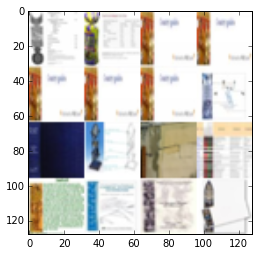

In [3]:
#visualization
def stripe_images(indices):
    return np.hstack((images[:,:,:,i] for i in indices))
def tile_images(indices):
    return np.vstack([stripe_images(indices[i:i+4]) for i in range(0,16,4)])

query_ind = 52
ret = retrieve(query_ind)
plt.imshow(tile_images(ret[:16]))
plt.show()

#Product Quantization
Compute codes and cluster centroids for product quantization. Use **scipy.cluster.vq.kmeans** or **scipy.cluster.vq.kmeans2** for clustering. This computation have to be done only once for given data.

In [4]:
k = 256  #number of clusters
c = 4   #number of subspaces
pq_codes = np.zeros((n, c))
pq_centroids = np.zeros((k, m/c, c))

In [6]:
thetime = time.time()
for i in xrange(c):
    #fill pq_codes and pq_centroids here
    #for each c calculate centroids for subspace and codes
    (pq_centroids[:,:,i], pq_codes[:,i]) = scipy.cluster.vq.kmeans2(X[:, i * m/c : (i + 1) * m/c], k)
print time.time() - thetime

86.4985909462


Implement **pq_retrieve** function which performs seach using compressed data and returns indices ranked according to their distance to the query.

In [7]:
def pq_approx_dist(left, right):
    res = 0
    for i in xrange(c):
        res += cdist((pq_centroids[left[i],:,i],), (pq_centroids[right[i],:,i],))
    return res

In [8]:
def pq_retrieve(query_ind):
    # finding nearest centroid
    coeffs = np.zeros(c)
    for i in xrange(c):
        query = X[query_ind, i * m / c : (i + 1) * m / c].reshape((1, m / c))
        coeffs[i] = cdist(query, pq_centroids[:,:,i]).argmin()
    #print coeffs
    # calculating approx distances
    dist = np.zeros(n)
    for i in xrange(n):
        dist[i] = pq_approx_dist(coeffs, pq_codes[i])
    # returning result
    indices = np.argsort(dist)
    return indices

Results should look similar to previous method's visualization.

[ 211.   52.    6.   65.]
44.5785660744


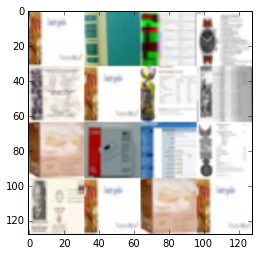

In [9]:
starttime = time.time()
pq_ret = pq_retrieve(query_ind)
print time.time() - starttime
plt.imshow(tile_images(pq_ret[:16]))
plt.show()

#Optimized Product Quantization
Compute codes, centroids and rotation matrix for OPQ ([original article](http://research.microsoft.com/pubs/187499/cvpr13opq.pdf)).


The main idea of the algorithm is to update clustering and rotation iteratively. Clustering update can be done via one step of kmeans algorithm: **scipy.cluster.vq.kmeans2(..., ..., iter=1)**.
New rotation matrix is calculated on every iteration via singular value decomposition according to the solution of [Orthogonal Procrustes problem](http://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem)

$$
R=\text{argmin}\|XR-Y\| \quad \text{s.t.} \quad {R^TR=I}
$$

$$
X^TY = USV^T
$$

$$
R = UV^T
$$

Beware of **scipy.linalg.svd** which outputs $V^T$ instead of $V$.

Original article recommends performing 100 iterations. However, it's going to take too long unless you optimize your code cleverly or use small subset of training data. Anyway, 10 iterations will be enough to outperform PQ.  


In [10]:
k = 256  #number of clusters
c = 4   #number of subspaces
R = np.eye(m, m)
opq_codes = np.zeros((n, c))
opq_centroids = np.zeros((k, m/c, c))
iterations = 10

#fill R, opq_codes and opq_centroids

In [11]:
thetime = time.time()
for iteration in range(iterations):
    #learning codebooks
    for i in xrange(c):
        (opq_centroids[:,:,i], opq_codes[:,i]) = \
          scipy.cluster.vq.kmeans2(X.dot(R)[:, i * m/c : (i + 1) * m/c], k, iter=1)
    #learning transformation
    Y = np.zeros(X.shape)
    for el in xrange(n):
        for subsp in xrange(c):
            Y[el, subsp * m / c : (subsp + 1) * m / c] = opq_centroids[opq_codes[el, subsp], :, subsp]
    (U, S, Vt) = scipy.linalg.svd(np.dot(np.transpose(X), Y))  
    R = np.transpose(U.dot(Vt))
print time.time() - thetime

560.29865694


Implement **opq_retrieve**. It should be very similar to **pq_retrieve**, apart from applying rotation to the query.

In [12]:
def opq_approx_dist(left, right):
    res = 0
    for i in xrange(c):
        res += cdist((opq_centroids[left[i],:,i],), (opq_centroids[right[i],:,i],))
    return res

In [13]:
def opq_retrieval(query):
    q = X[query,:].reshape((1, X.shape[1])).dot(R)
    coeffs = np.zeros(c)
    for i in xrange(c):
        coeffs[i] = cdist(q[:, i * m / c : (i + 1) * m / c], opq_centroids[:,:,i]).argmin()
    #print coeffs
    # calculating approx distances
    dist = np.zeros(n)
    for i in xrange(n):
        dist[i] = opq_approx_dist(coeffs, opq_codes[i])
    # returning result
    indices = np.argsort(dist)
    return indices

[ 142.  220.   47.  100.]
44.6947650909


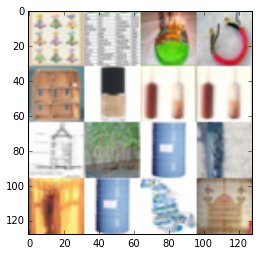

In [14]:
starttime = time.time()
opq_ret = opq_retrieval(query_ind)
print time.time() - starttime
plt.imshow(tile_images(opq_ret[:16]))
plt.show()

# Estimate the approximation error for PQ and OPQ

In [49]:
pqY = np.zeros(X.shape)
for el in xrange(n):
    for subsp in xrange(c):
        pqY[el, subsp * m / c : (subsp + 1) * m / c] = pq_centroids[opq_codes[el, subsp], :, subsp]

In [50]:
opqY = np.zeros(X.shape)
for el in xrange(n):
    for subsp in xrange(c):
        opqY[el, subsp * m / c : (subsp + 1) * m / c] = opq_centroids[opq_codes[el, subsp], :, subsp]

In [51]:
print np.linalg.norm(X - pqY)
print np.linalg.norm(X.dot(R) - opqY)

264.631227797
178.578251191


If needed, adjust the code to calculate and plot mean recall for PQ and OPQ

In [46]:
def comp_recall(retrieval, query, ground_truth, query_ind):
    ret = np.zeros(len(query_ind))
    preret = retrieval(query)
    i = 0
    for el in preret:
        if el in query_ind:
            ret[i] = el
            i += 1
    pos = np.flatnonzero(ret == ground_truth)[0]
    if (np.any(ret[:pos] == query)):
        pos = pos - 1
    recall = np.zeros(ret.shape)
    recall[pos:] = 1
    return recall

In [19]:
import random
starttime = time.time()
l = 100
query_ind = random.sample(range(n), l)
pq_recall = np.zeros(n)
opq_recall = np.zeros(n)
for q in query_ind:
    simple_ret = retrieve(q)
    for i in xrange(1 : len(simple_ret)):
        if simple_ret[i] in query_ind:
            ground_truth = simple_ret[i]#nearest neighbour
    pq_recall +=  1.0/l * comp_recall(pq_retrieve,  q, ground_truth, query_ind)
    opq_r1ecall += 1.0/l * comp_recall(opq_retrieval, q, ground_truth, query_ind)
print time.time() - starttime

[  34.   26.   40.  196.]
[  88.  131.   61.  183.]
[ 167.    6.  240.  154.]
[  34.  199.  252.   40.]
[ 235.  155.   87.  140.]
[ 248.  232.  161.  237.]
[ 223.  150.  236.  167.]
[ 233.  115.  205.  196.]
[  70.  161.  125.  104.]
[  52.   21.  251.  154.]
[  52.  187.  140.   64.]
[ 169.  247.  154.  187.]
[  99.  110.   90.  247.]
[ 207.  251.    8.  143.]
[ 249.  162.  160.  123.]
[   4.  237.  207.  208.]
[   0.  128.  163.   64.]
[ 142.    3.  243.   10.]
[  65.   81.   40.  131.]
[ 106.   32.  183.  144.]
[  74.  167.  231.   91.]
[ 181.   35.   28.   51.]
[  67.  138.  246.   40.]
[ 204.  140.  255.  154.]
[  70.  161.  125.  104.]
[  52.   21.  251.  154.]
[  86.   42.  235.  110.]
[ 137.   88.   55.   20.]
[  68.  106.  116.   68.]
[  88.  198.  165.  183.]
[ 171.   53.   52.   73.]
[  91.  121.   26.   57.]
[ 195.  215.   28.  127.]
[ 181.  135.   55.  123.]
[ 163.  186.  152.  230.]
[ 168.  185.  204.   96.]
[ 185.  140.  235.  231.]
[  30.   21.   55.  154.]
[  81.  107.

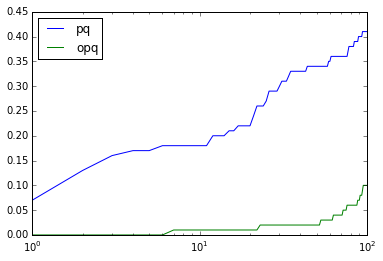

In [29]:
plt.plot(range(1,l+1), pq_recall, range(1,l+1), opq_recall)
plt.legend(('pq', 'opq'),'best')
plt.xscale('log')
plt.show()